In [104]:
import numpy as np
import random
import string
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [105]:
n = 30000
T = 25
k = 4

In [106]:
import string
import numpy as np

def generate_vocab(k):
    """
    Crée :
      - char_to_id : dict mapping chaque token à un entier
      - id_to_char : dict inverse
      - embeddings   : une matrice numpy [V, V] initialisée en one-hot (optionnel)
      - PAD_ID      : l’ID réservé pour le padding (0)
      - BEGIN_ID    : l’ID réservé pour le token de début 'b'
    où V = k + 2  (k lettres + 'PAD' + 'b')
    """
    assert k <= 26, "k ne doit pas dépasser 26"
    letters = list(string.ascii_uppercase)[:k]

    # Réservation des deux premiers indices
    PAD_ID   = 0
    BEGIN_ID = 1

    # Construction des mappings
    char_to_id = {'<PAD>': PAD_ID, 'b': BEGIN_ID}
    next_id = 2
    for ch in letters:
        char_to_id[ch] = next_id
        next_id += 1

    id_to_char = {i: c for c, i in char_to_id.items()}

    # (optionnel) embeddings one-hot qui inclut PAD et 'b'
    V = k + 2
    embeddings = np.eye(V, dtype=np.float32)

    return char_to_id, id_to_char, embeddings, PAD_ID, BEGIN_ID


In [107]:
char_to_id, id_to_char, embeddings, PAD_ID, BEGIN_ID = generate_vocab(k)
vocab_size = len(char_to_id)
char_to_id, id_to_char, embeddings, PAD_ID, BEGIN_ID


({'<PAD>': 0, 'b': 1, 'A': 2, 'B': 3, 'C': 4, 'D': 5},
 {0: '<PAD>', 1: 'b', 2: 'A', 3: 'B', 4: 'C', 5: 'D'},
 array([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]], dtype=float32),
 0,
 1)

In [108]:
import random

def generate_X_y_variable_length(T, dico, n):
    """
    Génère n séquences (X, y) de longueur variable entre 3 et T :
    - Chaque séquence commence par 'b'
    - Une lettre `target` apparaît une première fois dans le corps, puis à la fin
    - La cible `y` est la lettre suivant la première apparition du `target`
    """
    assert 'b' in dico
    letters = [k for k in dico if k != 'b' and k != '<PAD>']
    assert len(letters) >= 2
    assert T >= 3

    X_list = []
    y_list = []

    for _ in range(n):
        # 1) taille aléatoire entre 3 et T
        seq_len = random.randint(3, T)

        target = random.choice(letters)

        # corps length = seq_len - 2 ('b' en début + target à la fin)
        body_len = seq_len - 2

        # Position du target dans le corps (0 à body_len-1)
        insert_pos = random.randint(0, body_len - 1)

        # 2) Génère les lettres du corps
        middle_letters = []
        for i in range(body_len):
            if i == insert_pos:
                middle_letters.append(target)
            else:
                # choisit une autre lettre que target
                other_choices = [l for l in letters if l != target]
                middle_letters.append(random.choice(other_choices))

        # 3) Monte la séquence complète
        seq = ['b'] + middle_letters + [target]

        # 4) Trouve la première occurrence du target et la lettre qui suit
        idx = seq.index(target)  # renvoie insert_pos+1 (car 'b' en position 0)
        y = seq[idx + 1]

        X_list.append(seq)
        y_list.append(y)

    return X_list, y_list


In [109]:
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, X_list, y_list, char_to_id):
        self.X_list     = X_list
        self.y_list     = y_list
        self.char_to_id = char_to_id

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        seq = self.X_list[idx]         # ex ['b','A','C',...]
        # encodage en LongTensor d’indices:
        indices = torch.tensor([self.char_to_id[c] for c in seq], dtype=torch.long)
        label   = torch.tensor(self.char_to_id[self.y_list[idx]]-2, dtype=torch.long)
        return indices, label



In [110]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    seqs, labels = zip(*batch)
    padded_seqs = pad_sequence(seqs, batch_first=True, padding_value=PAD_ID)  # [B, L]
    labels = torch.stack(labels)
    # Mask = True partout sauf là où on a pad
    attention_mask = (padded_seqs != PAD_ID)  # [B, L], bool
    return padded_seqs, attention_mask, labels


In [111]:
X_list, y_list = generate_X_y_variable_length(T, char_to_id, n)
y_list[0]

'B'

In [112]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# 1) Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X_list, y_list, test_size=0.2, random_state=42
)

# 2) Créer les Dataset en utilisant char_to_id
train_dataset = SequenceDataset(X_train, y_train, char_to_id)
test_dataset  = SequenceDataset(X_test,  y_test,  char_to_id)

# 3) Créer les DataLoader avec collate_fn
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

# 4) Vérif rapide
xb, attention_mask, yb = next(iter(train_loader))
print(xb.shape, xb.dtype)           # [B, L], torch.long
print(attention_mask.shape)         # [B, L], torch.bool
print(yb.shape, yb.dtype)           # [B], torch.long

# 5) Lancer l'entraînement
# train_loss_list, test_loss_list, test_acc_list = train_model(
#     model, train_loader, test_loader,
#     epochs=10, lr=0.001, device=device
# )


torch.Size([32, 25]) torch.int64
torch.Size([32, 25])
torch.Size([32]) torch.int64


In [113]:
num_classes = k

In [157]:
def token_accuracy(preds, targets):
    """
    Calcule l'accuracy lettre par lettre (token par token).
    """
    pred_classes = torch.argmax(preds, dim=-1)  # [B, T]
    correct = (pred_classes == targets).float()
    return correct.mean().item()

def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()  # attente [B, C, T] vs [B, T]

    train_loss_list = []
    test_loss_list = []
    test_acc_list = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0

        for xb, attention_mask, yb in train_loader:
            xb, attention_mask, yb = xb.to(device), attention_mask.to(device), yb.to(device)  # xb: [B, T, D], yb: [B, T]
            assert 0 <= yb.min() and yb.max() < num_classes, "Label hors bornes !"
            preds = model(xb, attention_mask)                      # preds: [B, T, C]
    
      # -> [B, C, T] pour CrossEntropy

            loss = criterion(preds, yb)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_list.append(loss.item())
            total_train_loss += loss.item()

        # 🔍 Validation à la fin de l'epoch
        model.eval()
        total_val_loss = 0
        total_acc = 0
        total_samples = 0
        with torch.no_grad():
            for xb, attention_mask, yb in test_loader:
                xb, attention_mask, yb = xb.to(device), attention_mask.to(device), yb.to(device)
                preds = model(xb, attention_mask)  # [B, T, C]

                val_loss = criterion(preds, yb)
                total_val_loss += val_loss.item()
                test_loss_list.append(val_loss.item())

                acc = token_accuracy(preds, yb)
                total_acc += acc * xb.size(0)
                total_samples += xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(test_loader)
        avg_val_acc = total_acc / total_samples
        test_acc_list.append(avg_val_acc)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")

    return train_loss_list, test_loss_list, test_acc_list



In [158]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # pe : [1, max_len, d_model]
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)                # shape → [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x : [B, L, d_model]
        x = x + self.pe[:, :x.size(1), :]   # on slice sur la dimension length
        return x


In [159]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionOnlyBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
        self.attn_weights = None

    def forward(self, x, attention_mask):
        # x: [B, L, D], attention_mask: [B, L] (bool)
        B, L, D = x.shape
        Q = self.Wq(x)              # [B, L, D]
        K = self.Wk(x)              # [B, L, D]
        V = self.Wv(x)              # [B, L, D]

        # 1) scores bruts Q·K^T
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (D ** 0.5)  # [B, L, L]

        # 2) masque causal (empêcher de voir le futur)
        causal_mask = torch.triu(torch.ones(L, L, device=x.device, dtype=torch.bool), diagonal=1)
        scores = scores.masked_fill(causal_mask.unsqueeze(0), float('-inf'))

        # 3) masque de padding
        #    pad_mask[b, j] == True si c'est un PAD → on veut masquer la colonne j
        pad_mask = ~attention_mask               # [B, L]
        scores = scores.masked_fill(pad_mask.unsqueeze(1), float('-inf'))  # [B, L, L]

        # 4) softmax + fusion
        attn = F.softmax(scores, dim=-1)         # [B, L, L]
        self.attn_weights = attn
        out  = torch.matmul(attn, V)             # [B, L, D]

        return self.norm(out + x)


class AttentionOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, num_classes, d_model=128, num_layers=2, max_len=100, pad_id=0):
        super().__init__()
        # 1) Embedding d’indices → vecteurs float
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=d_model,
            padding_idx=pad_id
        )
        # 2) Positional Encoding (doit prendre et renvoyer [B, L, d_model])
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        # 3) Blocs d’attention uniquement
        self.layers = nn.ModuleList([AttentionOnlyBlock(d_model) for _ in range(num_layers)])
        # 4) Tête de classification
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x, attention_mask):
        # x: [B, L] (LongTensor d’indices), attention_mask: [B, L] (bool)
        x = self.embedding(x)           # → [B, L, d_model]

        x = self.pos_encoder(x)         # → [B, L, d_model]
        for layer in self.layers:
            x = layer(x, attention_mask)
        x = x[:, -1, :]                 # on ne garde que le dernier pas
        return self.classifier(x)       # → [B, num_classes]


In [160]:
model = AttentionOnlyTransformer(vocab_size=vocab_size, num_classes=num_classes, d_model=256, num_layers=2, max_len=T)

In [161]:
train_loss_list, test_loss_list, test_acc_list = train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device=device)

Epoch 1/10 | Train Loss: 1.1917 | Val Loss: 1.1219 | Val Acc: 0.4853
Epoch 2/10 | Train Loss: 1.1404 | Val Loss: 1.0965 | Val Acc: 0.4930
Epoch 3/10 | Train Loss: 1.0976 | Val Loss: 1.2027 | Val Acc: 0.4800
Epoch 4/10 | Train Loss: 1.0865 | Val Loss: 1.0584 | Val Acc: 0.5140
Epoch 5/10 | Train Loss: 1.0773 | Val Loss: 1.0710 | Val Acc: 0.5005
Epoch 6/10 | Train Loss: 1.0829 | Val Loss: 1.0930 | Val Acc: 0.4733
Epoch 7/10 | Train Loss: 1.0784 | Val Loss: 1.0345 | Val Acc: 0.5353
Epoch 8/10 | Train Loss: 1.0609 | Val Loss: 1.3599 | Val Acc: 0.4675
Epoch 9/10 | Train Loss: 1.1532 | Val Loss: 1.1387 | Val Acc: 0.4693
Epoch 10/10 | Train Loss: 1.2026 | Val Loss: 1.2611 | Val Acc: 0.3820


In [170]:
def plot_attention_matrices_with_accuracy(model, X, char_to_id, special_char='A', special_value=7, device=device, n_layers=1):

    embeddings = np.eye(k)
    model.eval()

    num_sequences = len(X[0])
    fig, axs = plt.subplots(num_sequences, 2, figsize=(14, 3.5 * num_sequences))

    if num_sequences == 1:
        axs = [axs]

    for i in range(num_sequences):


        x_tensor = X[0][i].to(device)  # [1, T]
        attention_mask = X[1][i].to(device)
        print(i)
        with torch.no_grad():
            preds = model(x_tensor, attention_mask).squeeze(0)  # [T, 1]
        end =T+1

        for k_layer in range(n_layers):
            attn = model.layers[k_layer].attn_weights  # [B, L, L]

            

            sns.heatmap(attn[0, :end, :end].cpu().numpy(), cmap="viridis", square=True, cbar=True, ax=axs[i][k_layer])





    plt.tight_layout()
    plt.show()
    return fig

In [171]:
def decode_x_to_letters(x_tensor, id_to_char):
    """
    Convertit un tenseur [B, T, D] en liste de séquences de lettres.

    Args:
        x_tensor: tenseur de taille [B, T, D] (one-hot ou proche de one-hot)
        id_to_char: dictionnaire id -> lettre (ex: {0: 'A', 1: 'B', ...})

    Returns:
        List[str]: liste de chaînes de lettres, une par séquence du batch.
    """
    print(x_tensor)
    x_ids = torch.argmax(x_tensor, dim=-1).cpu().numpy()  # [B, T]
    sequences = []
    for row in x_ids:
        letters = [id_to_char[i] for i in row]
        sequences.append("".join(letters))
    return sequences


In [172]:
sequences = next(iter(test_loader))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


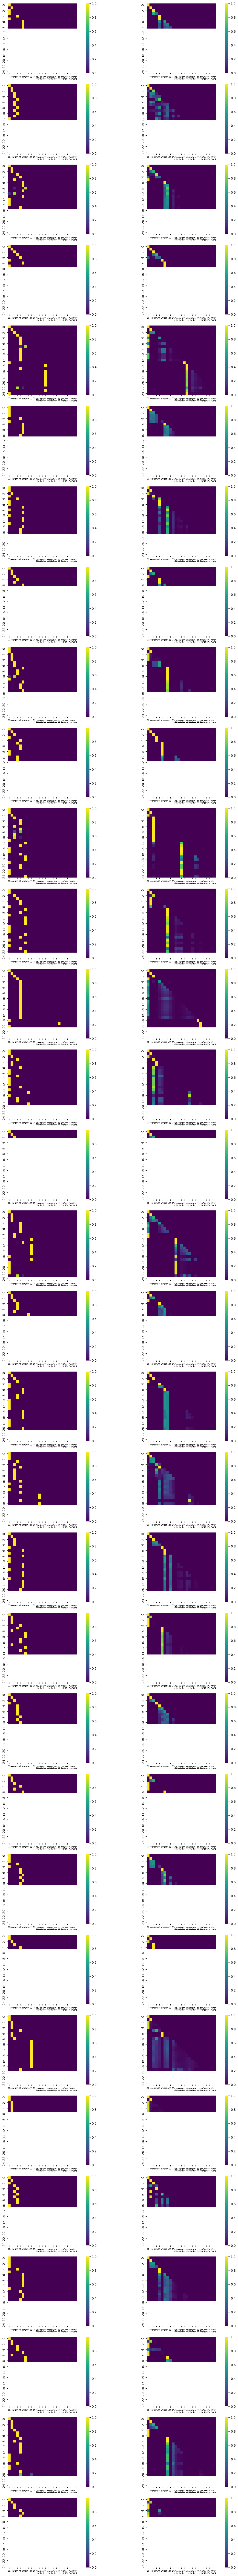

In [173]:
fig = plot_attention_matrices_with_accuracy(model, sequences, char_to_id, special_char='A', special_value=7, device=device, n_layers=2)